In [1]:
# Fill in your name using the format below and student ID number
your_name = "HOFFMAN, WOUTER"
student_id = "0899958"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [6]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available
#Allow memory growth
tf.config.experimental.set_memory_growth(gpus[0], True)


In [7]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import seaborn as sn

In [8]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi WOUTER, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [9]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [10]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [11]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [12]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [13]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [14]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

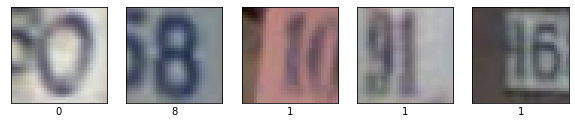

In [15]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [16]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
            print(learning_curves)
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
        
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

model built
Loading model from file
{'loss': [2.2450295928802357, 2.2334290914116495, 2.233521135541034], 'accuracy': [0.19021465, 0.19084413, 0.19085988], 'val_loss': [2.233103321821235, 2.2331330868508568, 2.2330902650761937], 'val_accuracy': [0.19097376, 0.19097376, 0.19097376]}
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233429  0.190215  2.233090    

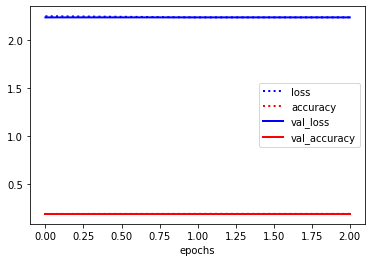

In [17]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print('model built')
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=True, epochs=3, batch_size=32)

model built
Loading model from file
{'loss': [2.2450295928802357, 2.2334290914116495, 2.233521135541034], 'accuracy': [0.19021465, 0.19084413, 0.19085988], 'val_loss': [2.233103321821235, 2.2331330868508568, 2.2330902650761937], 'val_accuracy': [0.19097376, 0.19097376, 0.19097376]}
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233429  0.190215  2.233090    

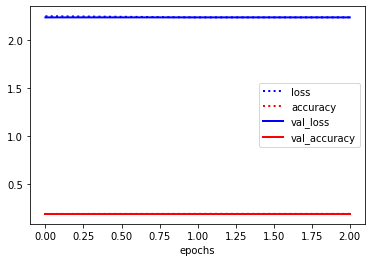

In [18]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/10
63544/63544 [==============================] - 5s 75us/sample - loss: 2.1788 - accuracy: 0.2162 - val_loss: 1.7548 - val_accuracy: 0.3890
Epoch 2/10
63544/63544 [==============================] - 4s 69us/sample - loss: 1.4903 - accuracy: 0.4934 - val_loss: 1.3631 - val_accuracy: 0.5454
Epoch 3/10
63544/63544 [==============================] - 4s 68us/sample - loss: 1.2423 - accuracy: 0.5949 - val_loss: 1.1603 - val_accuracy: 0.6306
Epoch 4/10
63544/63544 [==============================] - 4s 69us/sample - loss: 1.1124 - accuracy: 0.6477 - val_loss: 1.1519 - val_accuracy: 0.6298
Epoch 5/10
63544/63544 [==============================] - 4s 69us/sample - loss: 1.0100 - accuracy: 0.6836 - val_loss: 0.9834 - val_accuracy: 0.6918
Epoch 6/10
63544/63544 [==============================] - 4s 70us/sample - loss: 0.9409 - accuracy: 0.7065 - val_loss: 0.9969 - val_accuracy: 0.6863
Epoch 7/10
63544/63544 [=============

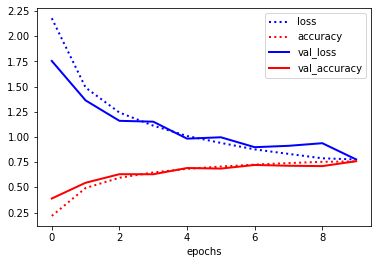

In [17]:
def build_model_1_1():
       
    # Initialize a sequential model
    model = models.Sequential()
    # input layer
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    # Hidden layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu')) 
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return model  
    
    pass



run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=128)


answer_q_1_1 = """
I tried networks of 3-5 layers with 2^x nodes (range: 32-2048), aiming for a low complexity to minimize overfitting but high enough complexity learn the task. 
Batch size was tested in range[32, 64, 128, 256]. I chose the most common activation functions (ReLu, softmax).
I tried regular rmsprop and adam, the last of which worked best. Cross-entropy was found to work slightly better than KL-divergence. 
The model performs fairly well, but increasingly starts overfitting after 10 epochs.
"""

print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [23]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
{'loss': [1.920964021144249, 1.3162097554955452, 1.1181615997018133, 1.0039403449524025, 0.9171552922523668, 0.8537357426494131, 0.8072995592781508, 0.7683979649245402, 0.7337508221634926, 0.7028929238938931], 'accuracy': [0.32262683, 0.57187146, 0.6467959, 0.6849742, 0.71276593, 0.7342629, 0.74828464, 0.7600875, 0.77104056, 0.7807031], 'val_loss': [1.5754355520315766, 1.200736474374051, 1.0849430886420668, 0.9830126644959194, 0.9259485860989544, 0.9300589259293454, 0.820426685473779, 0.860031950794188, 0.7689041777532621, 0.7594857527017068], 'val_accuracy': [0.46641907, 0.6199408, 0.6578964, 0.6940266, 0.7108328, 0.7117769, 0.7462076, 0.728709, 0.7642727, 0.7659722]}
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
den

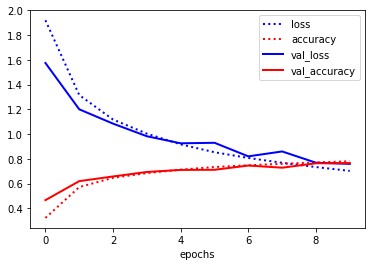

In [24]:
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    
    # Initialize a sequential model
    model = models.Sequential()
    # input layer
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    # Hidden layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu')) 
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return model  

    pass

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=10, batch_size=128)




answer_q_1_2 = """
               The images were converged to grey scales. As with humans not shape colors but only the shape contours are needed for classifying numbers. 
               By removing colors we remove a lot of unuseful information (noise) from the data, while keeping the information needed for the task. 
               This results in a slightly improved accuracy even though basically two third of the data has been removed, as well as faster training time (difference of +- 1s per sample). 
               This models starts overfitting similar to model_1_1 after about 10 epochs. Regularization is needed in order to prevent overfitting in further training.
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/40
63544/63544 [==============================] - 4s 65us/sample - loss: 2.4160 - accuracy: 0.2115 - val_loss: 2.0763 - val_accuracy: 0.2715
Epoch 2/40
63544/63544 [==============================] - 4s 57us/sample - loss: 1.7530 - accuracy: 0.4149 - val_loss: 1.5585 - val_accuracy: 0.4985
Epoch 3/40
63544/63544 [==============================] - 3s 54us/sample - loss: 1.5131 - accuracy: 0.5292 - val_loss: 1.4316 - val_accuracy: 0.5631
Epoch 4/40
63544/63544 [==============================] - 4s 56us/sample - loss: 1.3704 - accuracy: 0.5939 - val_loss: 1.3523 - val_accuracy: 0.6051
Epoch 5/40
63544/63544 [==============================] - 4s 57us/sample - loss: 1.2980 - accuracy: 0.6238 - val_loss: 1.3632 - val_accuracy: 0.6023
Epoch 6/40
63544/63544 [==============================] - 4s 58us/sample - loss: 1.2390 - accuracy: 0.6506 - val_loss: 1.2032 - val_accuracy: 0.6607
Epoch 7/40
63544/63544 [=============

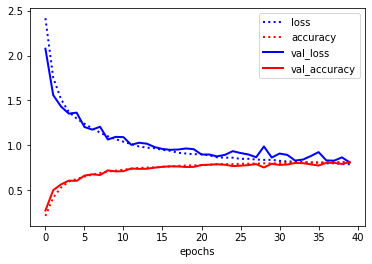

In [20]:
from tensorflow.keras import regularizers

def build_model_1_3():
    
    # Initialize a sequential model
    model = models.Sequential()
    # input layer
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    # Hidden layers
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

    pass


run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=40, batch_size=128)


answer_q_1_3 = """ I tried both l1 and a l2 regularizer, for regularization factors in range[0.0001, 0.0005 0.001, 0.005, 0.01], where an l2 regularizer with a factor 0f 0.001 proved to work best. Explored parameter settings but found all (hyper)paramaters as in model_1_2 to perform the best. The model performs can now train longer without overfitting (up to 40 epochs), leading to a slightly higher accuracy compared to model_1_1 and _1_2 (81% vs 77%). 
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/25
63544/63544 [==============================] - 28s 443us/sample - loss: 2.1468 - accuracy: 0.2255 - val_loss: 1.3750 - val_accuracy: 0.5710
Epoch 2/25
63544/63544 [==============================] - 23s 366us/sample - loss: 0.9686 - accuracy: 0.6885 - val_loss: 0.5180 - val_accuracy: 0.8411
Epoch 3/25
63544/63544 [==============================] - 23s 368us/sample - loss: 0.5987 - accuracy: 0.8182 - val_loss: 0.4152 - val_accuracy: 0.8720
Epoch 4/25
63544/63544 [==============================] - 23s 367us/sample - loss: 0.4823 - accuracy: 0.8587 - val_loss: 0.3605 - val_accuracy: 0.8904
Epoch 5/25
63544/63544 [==============================] - 23s 369us/sample - loss: 0.4160 - accuracy: 0.8794 - val_loss: 0.2876 - val_accuracy: 0.9141
Epoch 6/25
63544/63544 [==============================] - 23s 366us/sample - loss: 0.3772 - accuracy: 0.8930 - val_loss: 0.2755 - val_accuracy: 0.9197
Epoch 7/25
63544/63544 [=

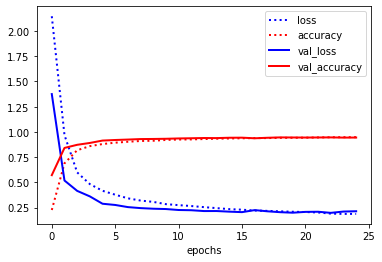

In [21]:
def build_model_2_1():
    
    # Initialize model
    model = models.Sequential()
    
    # Add double convolutional layers, followed by maxpooling and increasing dropout rates
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3)) 
    # Flatten convolution part of model
    model.add(layers.Flatten())
    # Add one last non-convolutional hidden layer to interpret the convolutional base of the model and continue with dropouts
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    # Add the output layer
    model.add(layers.Dense(10, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

    pass



run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=25, batch_size=256)

answer_q_2_1 = """After trying models of 3-5 layers, a VGG-like model with 3 double layers with at most 128 filters per convolutional layer performed best. Ended up with three double layers of (32, 64, 64) filters. Cross entropy was found to outperform KL-divergence as loss function, as did adam compared to rmsprop. Zero-padding was applied to all cconvolutional layers to be able to build this deeper model. Chose to match the number fo filters in the last convolutional layer with the last dense layer to best match this with the complexity of the convolutional layers. 2,2 max pooling is applied after every double layer to make the model more robust, and increasing dropouts were added to regularize the model. The model performs much better than those in Q1, with acc of +- 94% without overfitting."""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [25]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# copy preprocessed dataset
augmented_split = preprocessed_split


train_datagen = ImageDataGenerator(
      rotation_range=0.2,     # Rotate image up to 20 degrees
      shear_range=0.1,       # Shear (slant) the image up to 0.1 degrees
      zoom_range=0.15,        # Zoom in up to 15%
      horizontal_flip=False,  # Don't horizontally flip the image
      fill_mode='nearest')


it_train = train_datagen.flow(augmented_split[0], augmented_split[2], batch_size=256)

steps = int(X_train.shape[0] / 256)
run_evaluation("model_2_2", build_model_2_1, (it_train, augmented_split[1], augmented_split[3]), base_dir, 
               train=True, generator = True, epochs=30, batch_size=None, steps_per_epoch = steps)



answer_q_2_2 = """
               I chose only to apply a very slight zoom, shear and rotation, not to destroy too much data due to the low resolution. I did not apply any height or width shifts as this would go against the important quality inherent to the dataset which is that target numbers are centered within the images. A horizontal flip was also against the nature of the task as this is not to also recognize mirrored numbers.
               The model performs overfits less compared to model_2_1, but still seemws to convergence between 94-95%.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

NameError: name 'build_model_2_1' is not defined

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [26]:
# HELPER FUNCTIONS TO GO TO/FROM THE PREDICTION INDEX TO THE ACTUAL NUMBER

# Function to get the actual number displayed in the image 
def to_original_label(x):
    if(x == 9):
        label = 0
    else:
        label = x + 1
    
    return label
    pass

# Function to get the actual number displayed in the image 
def from_original_label(x):
    if(x == 0):
        label = 9
    else:
        label = x - 1
    
    return label
    pass

0.9478819160319758


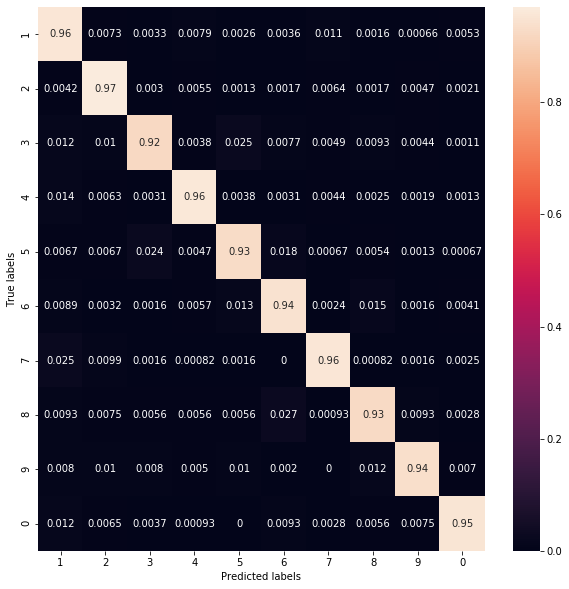

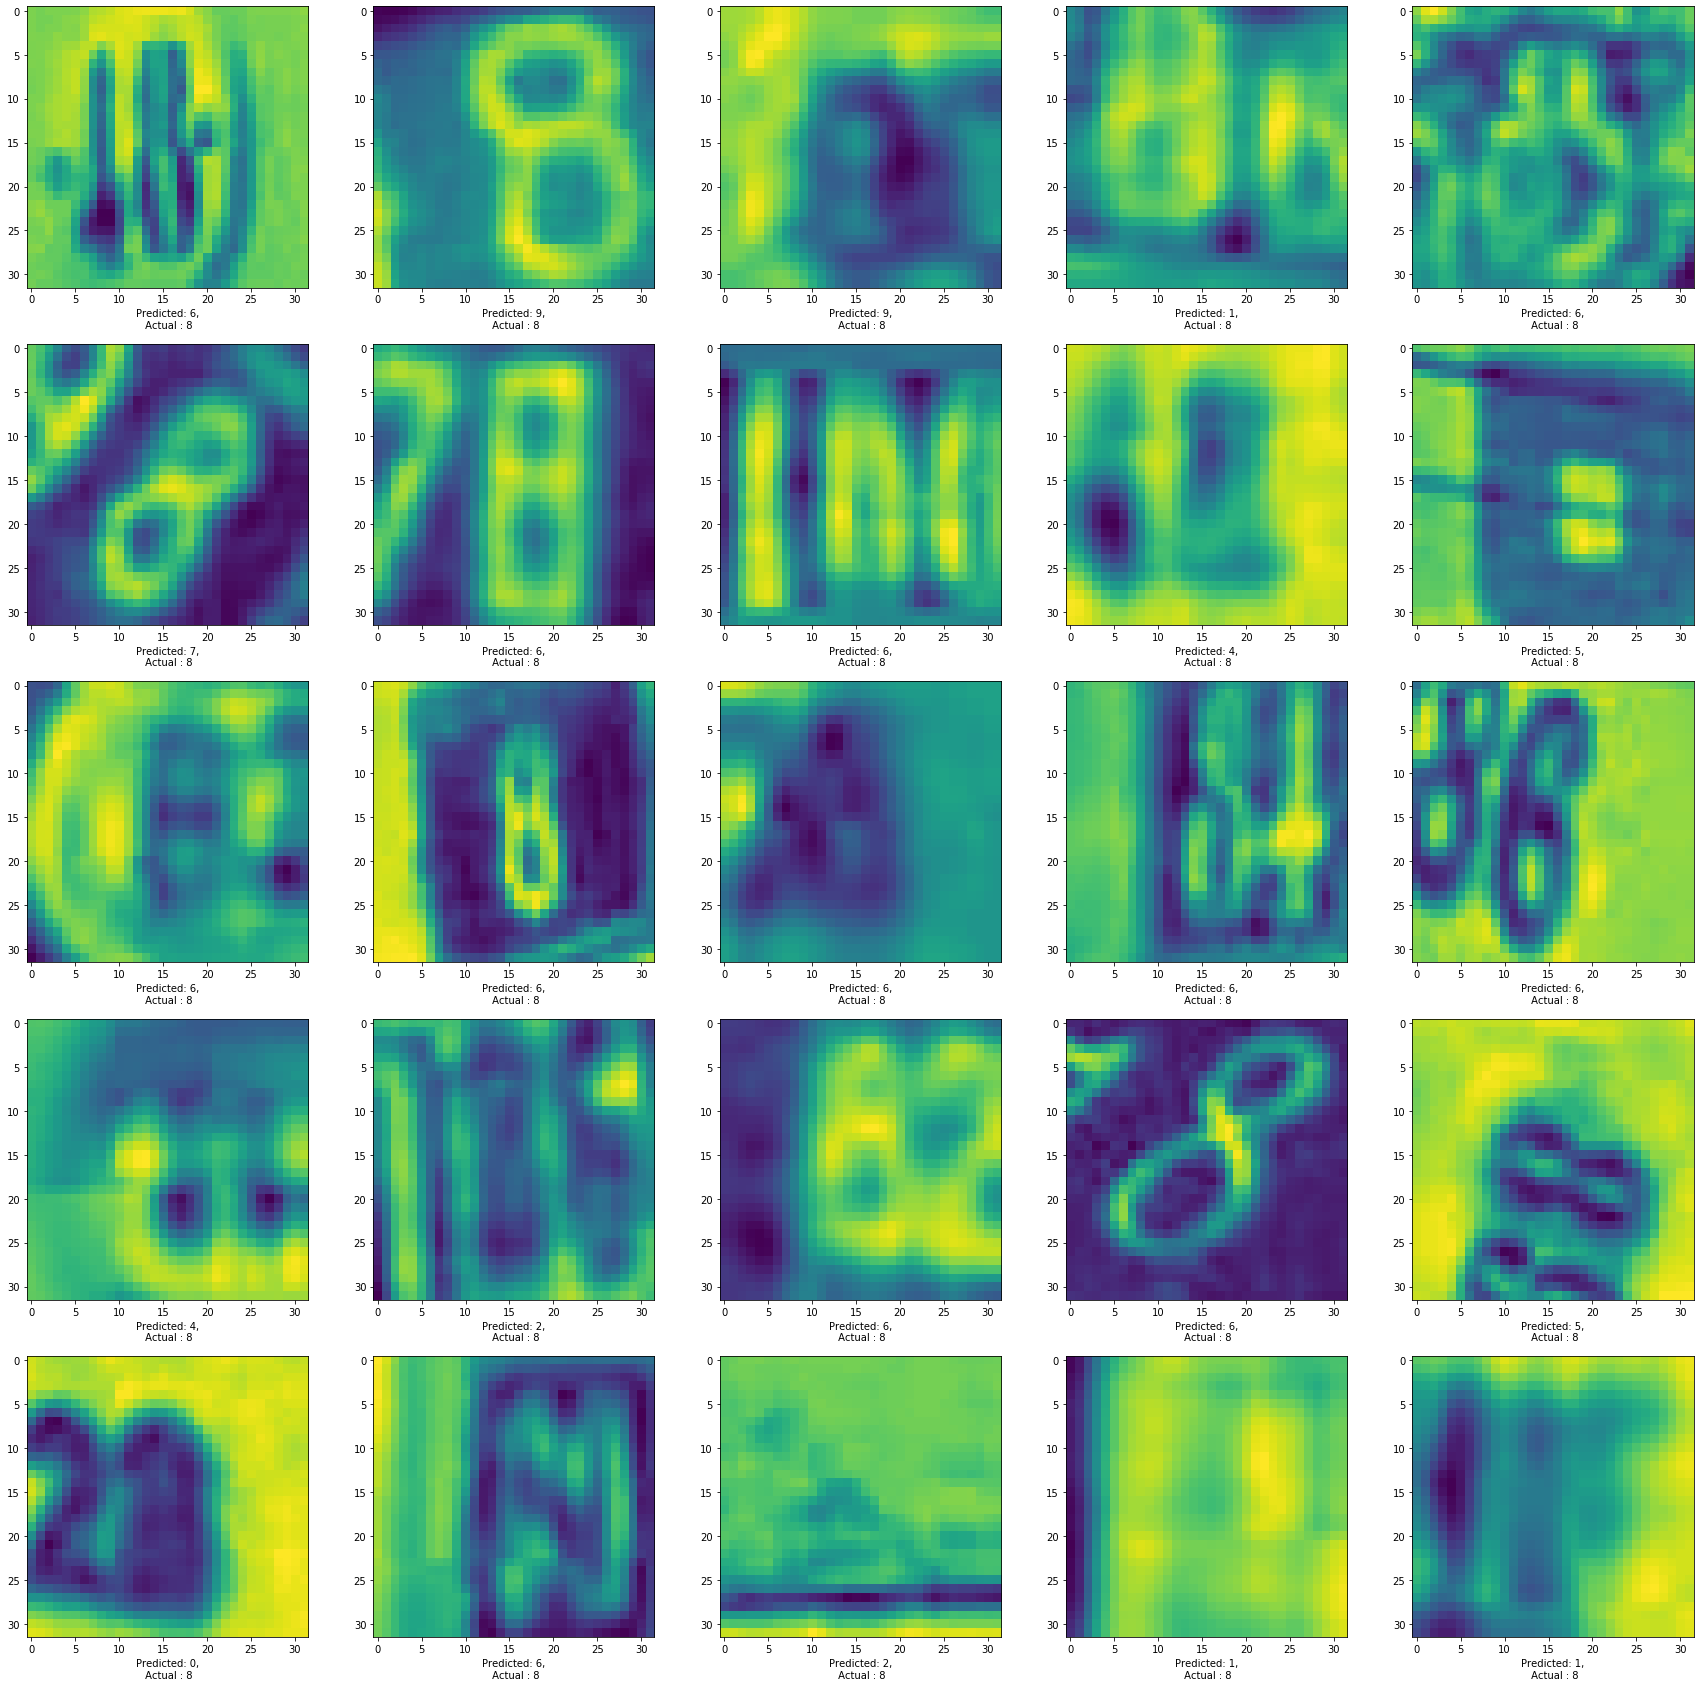

Answer is 759 characters long


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

# PREPARE DATA FOR ANALYSIS #
# Load the model from _2_2
model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
# Predict the classes of the validation dataset
y_pred = model.predict_classes(augmented_split[1])
# Get the true labels
y_test = np.argmax(augmented_split[3], axis=1)

# Calculate and print the model's accuracy on the validation set
test_accuracy_3_1 = accuracy_score(y_test, y_pred)
print(test_accuracy_3_1)

# Check for misclassifications and store the index numbers in 'misclassified_samples'
misclassified_samples = np.nonzero(y_test != y_pred)[0]



# PLOT CONFUSION MATRIX
def plot_confusion_matrix():
    #Get the (normalized) confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize = "true")
    # Transform to a pandas dataframe and add the labels such that they correspond to the actual number displayed on the images
    df_cm = pd.DataFrame(cm, index = [i for i in "1234567890"], columns = [i for i in "1234567890"])
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10,10))
    ax = sn.heatmap(df_cm, annot=True)
    ax.set(xlabel='Predicted labels', ylabel='True labels')
    plt.show()
    
    pass

plot_confusion_matrix()


# PLOT SPECIFIC MISCLASSIFICATIONS
def plot_misclassifications():

    # Get the indices for all misclassified samples with true label = 8 and store in misclassified_numbers
    misclassified_numbers = []        
    for i in misclassified_samples:
        if y_test[i] == from_original_label(8):
            misclassified_numbers.append(i)
    
    # Create figure with size=(30, 30)
    fig=plt.figure(figsize=(30, 30))
    # Get the first 25 misclassified samples and plot them with the true and predicted label
    for i in range(0, 25):    
        index = misclassified_numbers[i]
        predicted = to_original_label(y_pred[index])
        actual = to_original_label(y_test[index])
        fig.add_subplot(5, 5, i+1)
        plt.imshow(np.squeeze(augmented_split[1][index], axis=2))
        plt.xlabel("Predicted: %s,\n Actual : %s" % (predicted, actual))
       
    plt.show()
    
    pass

plot_misclassifications()



answer_q_3_1 = """Misclassifications were analyzed for the 8, as this is a hard number to classify as it contains the shape of many other numbers such as 3, 6 and 0. Still, the model performs well for the 8 (93%, about average). The mistakes are mainly samples in which the image quality is so low it is almost impossible to properly classify the number, and one example contains an 8 but is clearly centered on a 6 thus this is a faulty sample. Also in several of the example misclassifications a number was predicted that was in the image but was not the target, when close to the center. Overall the model seems to perform equally well for most numbers, slightly better for the 1 and 2 but this can be explained by the fact that these numbers are more common in the dataset."""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

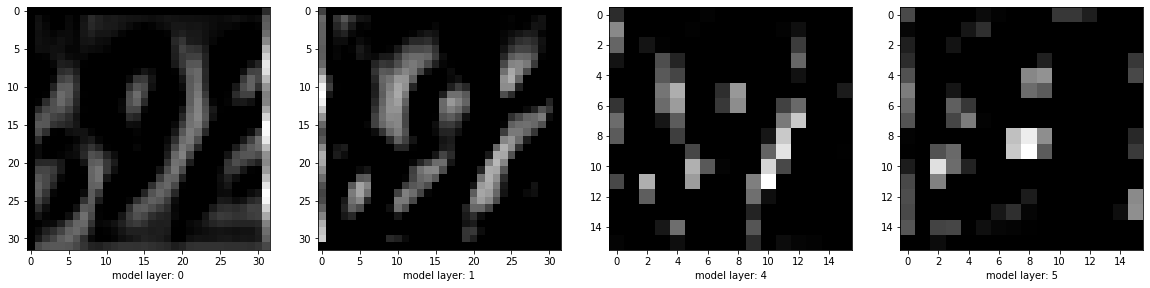

Answer is 465 characters long


In [37]:
from tensorflow.keras.models import Model

def plot_activations():
    
    # Load the model
    model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
    
    # List for storing indices of the convolutional layers
    convolutional_layers_index = []
    
    for i in range(len(model.layers)):
        layer = model.layers[i]
	# check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # Store indices of all convolution layers in a list to filter out other layers   
        convolutional_layers_index.append(i)
    
    # Select first image of test set as sample
    img = augmented_split[1][0]
    img = np.expand_dims(img, axis=0)        
    
    # Dict with interesting feature maps
    interesting_maps= {0:0, 1:2, 2:10, 3:18}
    
    fig=plt.figure(figsize=(20,20))

    # Show most interesting feature maps
    for key in interesting_maps:
        layer_index = convolutional_layers_index[key]
        
        model_fm = Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
        feature_maps = model_fm.predict(img)
        # plot filter channel in grayscale
        fig.add_subplot(1,4, key+1)
        plt.xlabel("model layer: %s" % (convolutional_layers_index[key]))
        plt.imshow(feature_maps[0, :, :, interesting_maps[key]-1], cmap='gray')
    plt.show()  
    

    # UNCOMMENT TO PLOT ALL FEATURE MAPSPlot all feature maps:
    
    #for i in convolutional_layers_index:
    #    
    #    nodes = model.layers[i].filters       
    #        
    #    model_fm = Model(inputs=model.inputs, outputs=model.layers[i].output)
    #    feature_maps = model_fm.predict(img)
    #    
    #    
    #    fig=plt.figure(figsize=(nodes, nodes))
    #    
    #    
    #    for i in range(0, nodes):
    #
    #       # plot filter channel in grayscale
    #        fig.add_subplot(8, nodes/8, i+1)
    #        plt.imshow(feature_maps[0, :, :, i-1], cmap='gray')
    #    plt.show()  

    
    pass

plot_activations()
answer_q_3_2 = """I chose to show the most interesting feature maps for the first 4 convolutional layers as those of the last 2 layers were too simple to deduct meaning. The first sample map highlights the shape of all the numbers. The second map focuses on the left edges of the numbers. The third map shows activation directly around the shape of the nine. The last sample shows activation in the hole of the nine and just below the o shape as if its looking for the holes of an 8."""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpose the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

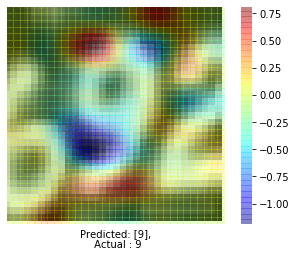

In [26]:
def plot_3_3():
    
    # LOAD MODEL AND IMAGE SAMPLE
    # Load the model
    model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
    # Select first image of test set as sample
    img = augmented_split[1][0]
    img = np.expand_dims(img, axis=0) 
    
    # STORE PREDICTED AND TRUE LABELS
    # Get the models class prediction for the sample, and the corresponding actual number
    pred = model.predict_classes(img)
    pred_original = to_original_label(pred)
    # Get the actual label and number
    actual = np.argmax(augmented_split[3][0])
    actual_original = to_original_label(actual)
    
    # CALCULATE ACTIVATION MAP
    # Get the weights of the last layer
    weights = model.layers[-1].get_weights()[0]
    # Create a new model based that accepts the same input, and has the last convolutional layer as output layer, so it returns the activations in the final layer to us
    activation_model = Model(inputs=model.inputs, outputs=model.layers[9].output)    
    activations = activation_model.predict(img)
    # Get weights of last layer for the predicted label
    activation_weights = weights[:,pred]
    # Calculate the dot product between the activations from the activation_model's prediction and the weights belonging to the predicted class
    activation_map = np.dot(activations, activation_weights)
    
    # PREPARE IMAGES FOR PLOTTING
    # Reduce map to 2 dimensions so it is suitable for plotting
    activation_map = np.squeeze(activation_map, axis = 3)
    activation_map = np.squeeze(activation_map, axis = 0)
    # Resize activation map to 32x32
    activation_map = cv2.resize(activation_map, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)

    # Prepare sample image for plotting
    img = np.squeeze(img, axis=3)
    img = np.squeeze(img, axis=0)
    
        
    # PLOT
    # Superimpose images
    plt.imshow(img, cmap= 'gray')
    heatmap = sn.heatmap(activation_map, annot=False, alpha = 0.28, cmap='jet')
    heatmap.set_xticks(())
    heatmap.set_yticks(())

    plt.xlabel("Predicted: %s,\n Actual : %s" % (pred_original, actual_original))
    # show plot
    plt.show()
    
    pass

plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/5
63544/63544 [==============================] - 56s 889us/sample - loss: 1.1495 - accuracy: 0.6061 - val_loss: 0.8194 - val_accuracy: 0.7271
Epoch 2/5
63544/63544 [==============================] - 57s 895us/sample - loss: 0.7852 - accuracy: 0.7389 - val_loss: 0.7076 - val_accuracy: 0.7635
Epoch 3/5
63544/63544 [==============================] - 58s 905us/sample - loss: 0.7006 - accuracy: 0.7695 - val_loss: 0.6898 - val_accuracy: 0.7684
Epoch 4/5
63544/63544 [==============================] - 57s 901us/sample - loss: 0.6377 - accuracy: 0.7889 - val_loss: 0.6204 - val_accuracy: 0.7952
Epoch 5/5
63544/63544 [==============================] - 57s 895us/sample - loss: 0.5962 - accuracy: 0.8048 - val_loss: 0.6084 - val_accuracy: 0.7976
Saving to file
Model stored in ./
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Par

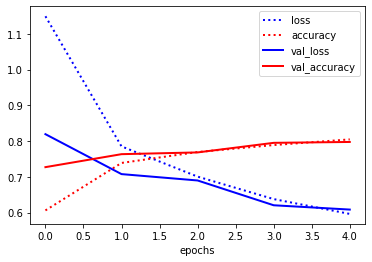

In [45]:
from tensorflow.keras.applications.vgg16 import VGG16

def build_model_4_1():
    
    model = models.Sequential()
    # Load the VGG convolutional models
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape = (32, 32, 3))

    # unfreeze the last layer
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        else:
            layer.trainable = False

    # Build the model
    model.add(conv_base)
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))  
    model.add(layers.Dropout(0.3)) 
    model.add(layers.Dense(10, activation='softmax'))
    # Compile model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model
    pass



run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=5, batch_size=256)


answer_q_4_1 = """Unfreezing the last layer gave a better result (80% vs 55% acc). The model starts overfitting after 5 epochs despite the dropouts. Transfer learning seems te work okay as the first 4 convolutional layers remain frozen and still provide a good base for predicting on our dataset, so VGG-16 does generalize well on our dataset but only to a certain extend. The model doesn't seem capable of trumping a CNN built especially for this dataset but it can speed up the training which is a tradeoff."""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe whathaha  you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer, PowerTransformer, StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier


import pickle
import gzip

def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    # load model_4_1
    model_4_1 = load_model_from_file(base_dir, 'model_4_1', extension='.h5')
    # Initialize a new model
    model = models.Sequential()
    # Add the convolutional part of model_4_1 to our model
    for layer in model_4_1.layers[:3]:
            model.add(layer)
        
    # Perform predictions with model       
    embedded_train = model.predict(evaluation_split[0])
    embedded_test = model.predict(evaluation_split[1])
    # Store the embedded datasets
    store_embedding(embedded_train, 'train')
    store_embedding(embedded_test, 'test')
    
    pass

def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    clf = svm.SVC(kernel='rbf')
    #clf= = RandomForestClassifier()
    pipe = make_pipeline(StandardScaler(), clf)
    
    return pipe
    pass

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
      """
    # Fit the pipeline to the data and predict on the test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Calculate, print and return the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy) 
    return accuracy

    pass

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    # Generate pipeline
    pipe = generate_pipeline()
    # Evaluate pipeline on embedded data
    evaluate_pipeline(pipe, X_train_embed, y_train ,X_test_embed, y_test)
    
    pass

# UNCOMMENT TO CREATE EMBEDDED DATASETS
#store_embeddings()

# Get the embedded training and test data
X_train_embed = load_embedding('train')
X_test_embed = load_embedding('test')
# Get the training and test labels
y_train = np.argmax(evaluation_split[2], axis=1)
y_test = np.argmax(evaluation_split[3], axis=1)
#Evaluate model
if(stop_training == False):
    evaluation_4_2(X_train_embed, y_train, X_test_embed, y_test)



answer_q_4_2 = """I tried both a random forest and a SVM with RBF kernel as classifier on the embedded training set, both resulted in an accuracy of approximately 81% so there was no clear winner between those two. Training of the SVM took quite long. It is clear that with an accuracy above 94%^the winner of this assignment is the CNN built in part 2 which was trained and designed specifically for this dataset."""



print("Pipeline:", generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

NameError: name 'os' is not defined